In [100]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [134]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.integrate

from quantum_systems import ODQD, GeneralOrbitalSystem

In [177]:
l = 5 # Number of eigenstates of the HO potential --> we use these functions to generate the single particle WF
grid_length = 10  # The width of the one-dimensional grid
num_grid_points = 101  # The number of discretized points on the grid.
# More points give better results for the single-particle basis at the cost of slower setup.
alpha = 1  # The strength of the Coulomb interaction 
a = 0.25  # The shielding parameter in the Coulomb interaction potential
omega = 0.25  # The frequency of the harmonic oscillator trap
potential=ODQD.HOPotential(omega)
nparticles = 2

odho = ODQD(l, grid_length, num_grid_points, a=a, alpha=alpha, potential=potential )
odho.u[0,0,0,0]

(1.134303287719311+0j)

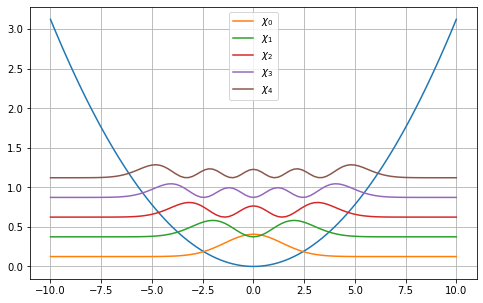

In [178]:
fig = plt.figure(figsize=(8, 5))

plt.plot(odho.grid, potential(odho.grid))

for i in range(l):
    plt.plot( odho.grid, np.abs(odho.spf[i]) ** 2 + odho.h[i, i].real, label=r"$\chi_{" + f"{i}" + r"}$" )

plt.grid()
plt.legend()
plt.show()

In [180]:
odho = ODQD(l, grid_length, num_grid_points, a=a, alpha=alpha, potential=potential )
system = GeneralOrbitalSystem(n=nparticles, basis_set=odho, anti_symmetrize=False)
#NB: when system is created, also odho is modified! Try printing odho.u[0,0,0,0] before and after generating system 
# with anti_symmetrise=True
system.u[0,0,0,0]

(1.134303287719311+0j)

In [182]:
tolerance = 1e-8
max_iter = 40
eigenv, coefficients = scipy.linalg.eigh(system.h)
E_old = eigenv

f = np.zeros( system.h.shape, dtype=np.complex128 )
density = np.zeros( system.h.shape , dtype=np.complex128 )

i=0
deltaE = 1
while i<max_iter and deltaE>tolerance:
    i += 1
    density = np.zeros( system.h.shape , dtype=np.complex128 )
    for j in range(nparticles*l):
        density += np.outer(coefficients[:,j], coefficients[:,j]) 
    
    for a in range(2*l):
        for b in range(2*l):
            f[a][b] = np.sum(density*system.u[a,:,:,b])

    f += system.h
    eigenv, coefficients = scipy.linalg.eigh(f)
    
    deltaE = sum( np.abs(E_old - eigenv) )/l
    E_old = eigenv

print(eigenv)

[2.1655575  2.1655575  2.29522373 2.29522373 2.38260829 2.38260829
 2.49533725 2.49533725 2.53136729 2.53136729]


In [161]:
len(f)

10